In [ ]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as md
import pickle as pkl
import xgboost
import shap
from tensorflow import keras
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler
from itertools import combinations, product
from src.colnames import topic_col, emotion_col, style_col, exclude_col
from utils import _pca_transform, plot_volume

%load_ext autoreload
%autoreload 2

### TODO:
- Qualitative traits - turn into point and line plot, align, interpret
- Plug overall evolution, per-year comparison, and qualitative comparison


In [2]:
df = pd.read_json('data/topic/data.jsonl', 
                        orient='records',
                        lines=True)

### Overall number of Tweets

In [3]:
style_short = [c for c in df.columns if 'rauh' in c or 'benoit' in c]

In [4]:
summary = df.groupby('entity').aggregate({'created_at': 'min',
                                          'text': 'count'}).reset_index()
summary['end_date'] = '2022-06-29'
summary[['end_date',
         'created_at']] = summary[['end_date',
                                   'created_at']].apply(pd.to_datetime)
summary['n_days'] = (summary['end_date'] - summary['created_at']).dt.days
summary['tweets_per_day'] = (summary['text'] / summary['n_days']).round(2)
summary.columns = ['entity', 'first tweet', '# tweets', 'last tweet', '# days', 'tweets per day']
summary = summary[['entity', '# tweets', 'first tweet', 'last tweet', '# days', 'tweets per day']]

In [5]:
summary

,entity,# tweets,first tweet,last tweet,# days,tweets per day
0,10DowningStreet,11595,2008-03-26,2022-06-29,5208,2.23
1,EUCouncil,5652,2012-12-04,2022-06-29,3494,1.62
2,EU_Commission,29621,2010-06-23,2022-06-29,4389,6.75
3,Europarl_EN,18485,2009-04-30,2022-06-29,4808,3.84
4,IMFNews,19361,2009-03-24,2022-06-29,4845,4.00
5,OECD,13558,2009-03-19,2022-06-29,4850,2.80
6,UN,42664,2008-12-20,2022-06-29,4939,8.64
7,ecb,14948,2010-04-28,2022-06-29,4445,3.36
8,scotgov,12090,2009-06-16,2022-06-29,4761,2.54


### Plot tweet volume

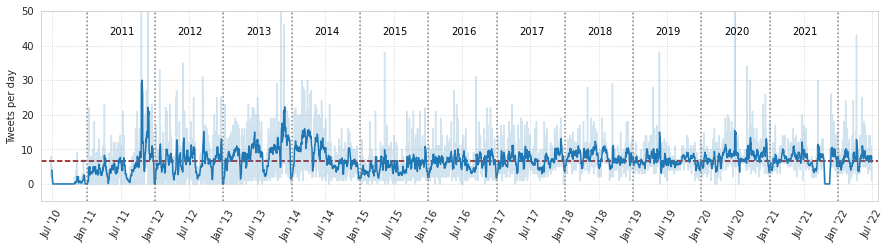

In [6]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plot_volume(df, interactive=False,
            figsize=(15,3.5), 
            plot_smooth_only=False,
            exclude_entities=set(df.entity.unique().tolist()) - set(['EU_Commission']),
            ylim=True, freq='D', roll_window=7)

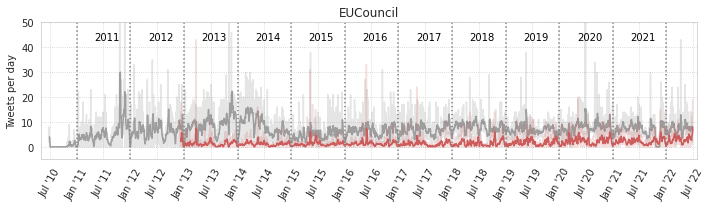

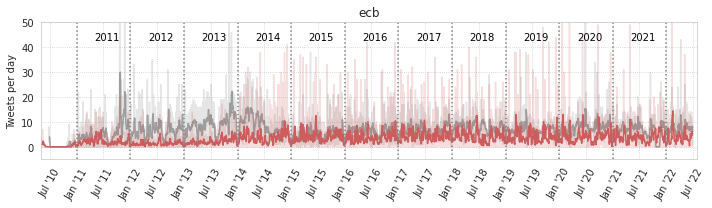

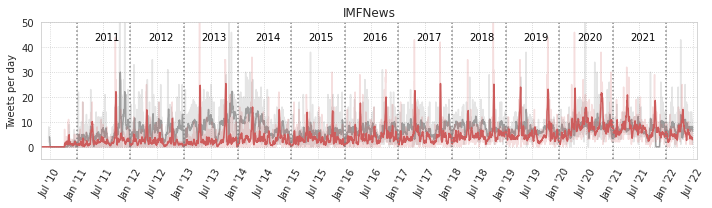

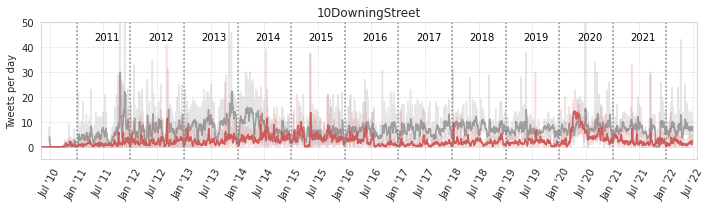

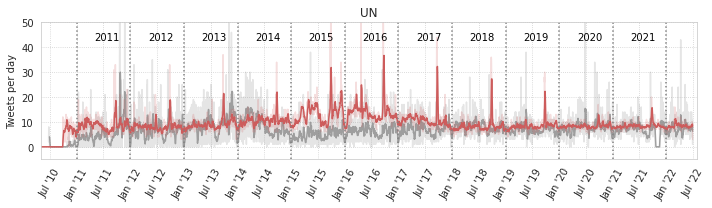

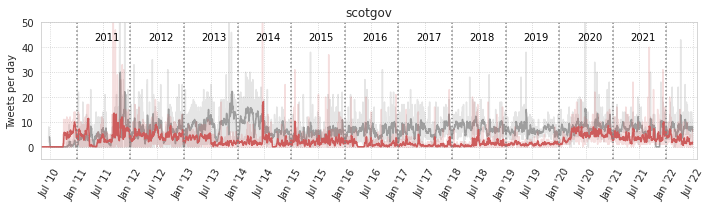

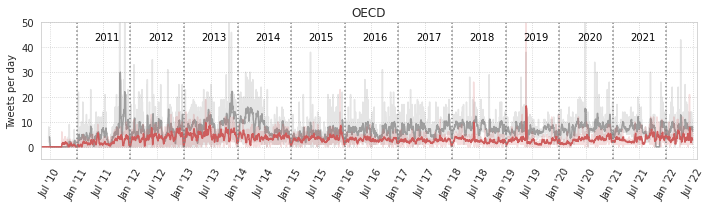

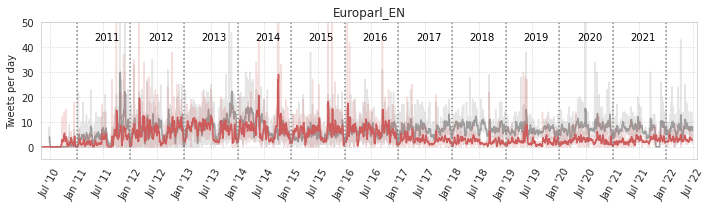

In [7]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
for entity in set(df.entity.unique().tolist()) - set(['EU_Commission']):
    plot_volume(df, interactive=False,
                figsize=(10,3), 
                plot_smooth_only=False,
                exclude_entities=set(df.entity.unique().tolist()) - set(['EU_Commission', entity]),
                ylim=True, freq='D', roll_window=7,
                multiple=True, colors=['grey', 
                                       'indianred'], 
                savename=entity)

## Style

#### Qualitative style comparison

In [8]:
df['n_mentions'] = df['text'].replace('[^@]','', regex=True).str.len()
df['n_hashtag'] = df['text'].replace('[^#]','', regex=True).str.len()
for c in ['n_hashtag', 'n_mentions', 'n_emojis']:
    df[c] = df[c] / df['benoit_sentence-length-words']

#### Style over time

In [9]:
df['year'] = df['created_at'].apply(lambda x: x.year)
df['month'] = df['created_at'].apply(lambda x: x.month)

In [5]:
style_targets = [c for c in df.columns if any(['rauh' in c, 
                                               'benoit' in c, 
                                               'alpha_ratio' in c])] + \
                ['n_hashtag', 'n_mentions', 'is_link', 'n_emojis']
sentiment_targets = [c for c in df.columns if 'sentiment' in c]
categories = ['multimodal', 'word complexity', 'action', 'readability',
              'readability', 'overall length', 'sentence complexity',
              'sentence complexity', 'word complexity', 'word complexity',
              'action', 'multimodal', 'multimodal', 'multimodal', 'multimodal',
              'sentiment', 'sentiment', 'sentiment']
mapdict = dict(zip(style_targets+sentiment_targets, categories))

In [6]:
new_names = ['% alphanumeric', 
             'frequency',
            'verb-to-noun ratio', 
             'Flesch-Kincaid Grade',
             'Flesch reading ease',
             '# words', 
             'sentence length (words)', 
             'sentence length (chars)', 
             'word length (syllables)',
             'word length (chars)', 
             '% nouns', 
             '% hashtag', '% mentions', 
             'has link', '% emojis',
             'negative sentiment', 'neutral sentiment', 'positive sentiment']

In [211]:
param_categories = ['alpha', 'sentence complexity', 'action', 
                    'readability', 'sentence complexity', 
                    'sentence complexity', 'word complexity', 
                    'word complexity', 
                    'alpha', 'alpha', 'alpha', 'alpha', 
                    'sentiment', 'sentiment', 'sentiment', 
                    'word complexity', 'readability', 'action']
sort_entities = ['10DowningStreet', 'scotgov', 
                 'UN', 'Europarl_EN', 'EUCouncil', 
                 'ecb', 'IMFNews', 'OECD']

### Within EU Commission, over time

In [212]:
df_standard = df.copy()
for c in style_targets + sentiment_targets:
    df_standard[c] = (df_standard[c] - df_standard[c].mean()) / df_standard[c].std()
grouped = df_standard[df_standard['entity']=='EU_Commission'].groupby('year')[style_targets + sentiment_targets].agg(np.nanmean).reset_index()

In [213]:
grouped_long = grouped.melt(id_vars='year')

In [214]:
grouped_long['category'] = grouped_long['variable'].map(mapdict)
grouped_long['variable'] = grouped_long['variable'].map(dict(zip(style_targets+sentiment_targets,
                                                                 new_names)))
grouped = grouped.rename(dict(zip(style_targets+sentiment_targets, new_names)),
                         axis=1)

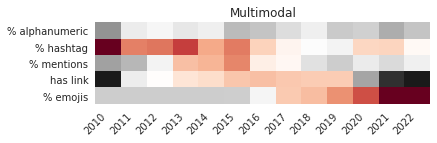

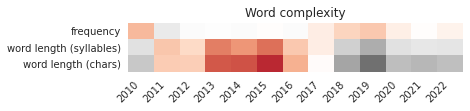

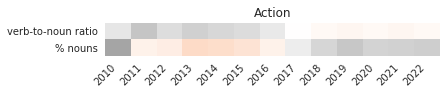

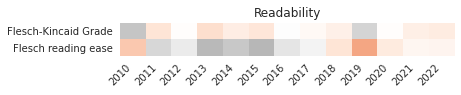

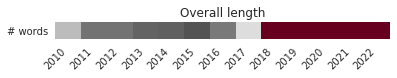

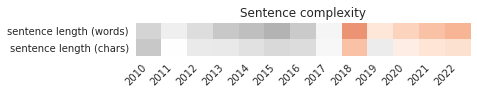

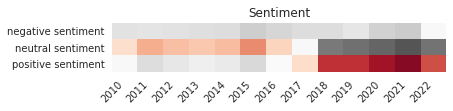

In [221]:
from sklearn.preprocessing import MinMaxScaler

for c in grouped_long.category.unique():
    sub_grouped = grouped[grouped_long[grouped_long['category']==c].variable.unique().tolist()]
    plt.subplots(figsize=(6,0.3*len(sub_grouped.columns)))
    sns.heatmap(sub_grouped.T, cmap='RdGy_r', center=.0, cbar=False,
                vmax=1, vmin=-1)
    plt.xticks(ticks=range(grouped.year.nunique()),
               labels=grouped.year.unique(),
               rotation=45)
    plt.yticks(rotation=0)
    plt.title(c.capitalize())
    plt.savefig(f'figs/heatmap_{c}.png', dpi=300, bbox_inches='tight')
    plt.show()

#### Similarity with different institutions, over time

In [17]:
# Overall similarity over time (Euclidean distance with other agencies)
# Overall discriminability (at three time steps)

#### Qualitative plot: overall similarity, per trait

In [394]:
bow_targets = [c for c in df_standard.columns if 'bow_500' in c]

alpha_targets = ['is_link',
                 'n_hashtag',
                 'n_mentions',
                 'n_emojis']

action_targets = ['rauh_verb-to-noun', 
                  'benoit_prop-noun']

sentence_targets = ['benoit_overall-length', 
                    'benoit_sentence-length-words',
                    'benoit_sentence-length-characters']

word_targets = ['rauh_frequency',
                'benoit_word-length-syllables',
                'benoit_word-length-characters']

readability_targets = ['rauh_readability', 'benoit_readability']

feature_set_names = ['style (all)', 
                     #'sentiment', 
                     #'Multimodal',
                     #'Action', 
                     #'sentence complexity',
                     #'word complexity', 
                     #'readability'
                    ]

feature_sets = [style_targets, 
                #sentiment_targets,
                #alpha_targets, 
                #action_targets,
                #sentence_targets, 
                #word_targets, 
                #readability_targets
               ]

In [395]:
perfs = []
for r in range(5):
    print(f'Run {r}')
    
    for i in df_standard.year.unique():
        print(f'Year {i}')

        for feature, name in zip(feature_sets, feature_set_names):
            for e in set(df_standard.entity.unique()) - set(['EU_Commission']):

                scaler = StandardScaler()

                # Make datasets
                trains = []; vals = [];

                try:
                    for en in [e, 'EU_Commission']:
                            trains.append(df_standard[(df_standard['year']==i) & 
                                                    (df_standard['entity']==en)].sample(1000, replace=True))
                            vals.append(df_standard[(df_standard['year']==i) & 
                                                  (df_standard['entity']==en)].sample(1000, replace=True))

                    trains = pd.concat(trains).sample(frac=1)
                    train_X = scaler.fit_transform(trains[feature].fillna(0).values)
                    train_y = trains['entity'].map({e: 1.0, 'EU_Commission': 0.0})
                    vals = pd.concat(vals).sample(frac=1)
                    val_X = scaler.fit_transform(vals[feature].fillna(0).values)
                    val_y = vals['entity'].map({e: 1.0, 'EU_Commission': 0.0})

                    # Define model
                    inputs = keras.Input(shape=(len(feature)))
                    x = keras.layers.Dense(units=len(feature))(inputs)
                    x = keras.layers.Dense(units=len(feature))(x)
                    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
                    model = keras.Model(inputs, outputs)
                    model.compile(optimizer='rmsprop', 
                                  loss=keras.losses.BinaryCrossentropy(from_logits=False),
                                  metrics='accuracy')

                    # Fit and evaluate
                    model.fit(train_X, train_y, epochs=100, 
                              verbose=0,
                              validation_split=.2, 
                              callbacks=keras.callbacks.EarlyStopping(patience=3))

                    # Plot
                    perfs.append((name, e, 
                                  round(model.evaluate(val_X, val_y, verbose=0)[1],3), 
                                  i, r))

                except:
                    continue
                    
perf_df = pd.DataFrame(perfs, columns=['name', 'entity', 'score', 'year', 'run'])

Run 0
Year 2020
Year 2009
Year 2011
Year 2022
Year 2012
Year 2019
Year 2018
Year 2021
Year 2017
Year 2013
Year 2014
Year 2010
Year 2015
Year 2016
Year 2008
Run 1
Year 2020
Year 2009
Year 2011
Year 2022
Year 2012
Year 2019
Year 2018
Year 2021
Year 2017
Year 2013
Year 2014
Year 2010
Year 2015
Year 2016
Year 2008
Run 2
Year 2020
Year 2009
Year 2011
Year 2022
Year 2012
Year 2019
Year 2018
Year 2021
Year 2017
Year 2013
Year 2014
Year 2010
Year 2015
Year 2016
Year 2008
Run 3
Year 2020
Year 2009
Year 2011
Year 2022
Year 2012
Year 2019
Year 2018
Year 2021
Year 2017
Year 2013
Year 2014
Year 2010
Year 2015
Year 2016
Year 2008
Run 4
Year 2020
Year 2009
Year 2011
Year 2022
Year 2012
Year 2019
Year 2018
Year 2021
Year 2017
Year 2013
Year 2014
Year 2010
Year 2015
Year 2016
Year 2008


In [396]:
perf_all = perf_df.copy()
perf_all.to_json('logs/classifiers_time.jsonl', orient='records', lines=True)

In [441]:
perf_df = perf_df.groupby(['name', 'entity', 'year']).score.mean().reset_index()
perf_wide = pd.pivot(perf_df[perf_df['year']>=2012], index=['name','entity'], 
                     columns='year', values='score').reset_index()

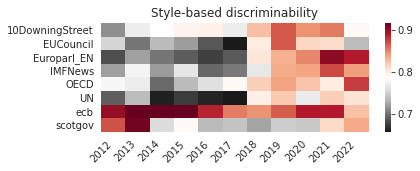

In [443]:
for c in perf_df['name'].unique():
    target_data = perf_wide[(perf_wide['name']==c) ]
    target_data = target_data.sort_values(by='entity')
    entities = target_data.entity.tolist()
    target_data = target_data.drop(['name', 'entity'], axis=1)
    plt.subplots(figsize=(6,2))
    sns.heatmap(target_data, cmap='RdGy_r', robust=True, square=False)
    plt.xticks(ticks=range(grouped.year.nunique()-2),
               labels=sorted(set(grouped.year.unique()) - set([2010,2011])),
               rotation=45, ha='center')
    plt.yticks(ticks=np.arange(0.5,8.5,1), labels=entities, rotation=0)
    plt.title('Style-based discriminability')
    plt.xlabel('')
    plt.show()

### Qualitative comparison

In [452]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

ests = []
for t in style_targets + sentiment_targets:
    scaler = StandardScaler()
    new_t_name = t.replace('-','_')
    data = df[df['year']>=2018].rename({t: new_t_name}, axis=1).fillna(0)
    data[new_t_name] = scaler.fit_transform(data[[new_t_name]])
    formula = f"{new_t_name} ~ C(entity, Treatment(reference='EU_Commission')) + {' + '.join(topic_col)}" # added topics for control
    
    # Specify model
    mod = smf.rlm(formula, data=data, M=sm.robust.norms.HuberT())
    
    # Freq workflow
    res = mod.fit()
    
    # Save estimates
    est_df = pd.DataFrame(res.params, columns=['param'])
    est_df['predictor'] = est_df.index.str.replace(r"C\(entity, Treatment\(reference='EU_Commission'\)\)\[T\.", "", 
                                                   regex=True)
    est_df['predictor'] = est_df['predictor'].str.replace(r"\]", "", regex=True)
    est_df['target'] = t
    est_df['p_val'] = res.pvalues.values
    est_df = est_df[~est_df['predictor'].isin(topic_col)]
    est_df = est_df.reset_index(drop=True)
    est_df = est_df[est_df['predictor']!='Intercept']
    ests.append(est_df)
    
# Make joint dataset
ests = pd.concat(ests)
ests['param'] = ests['param'] * (ests['p_val']<0.05).astype(int)
ests.drop('p_val', axis=1, inplace=True)

In [453]:
ests['category'] = ests['target'].map(mapdict)
ests['target'] = ests['target'].map(dict(zip(style_targets+sentiment_targets, new_names)))


In [454]:
ests_wide = ests.pivot(index='predictor',
                       columns='target', values='param')

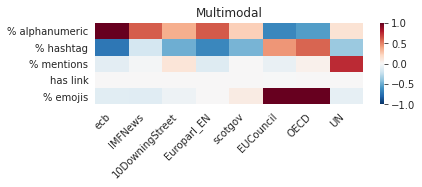

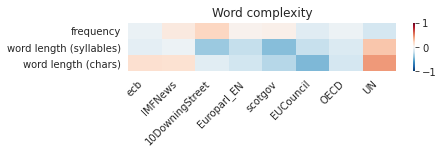

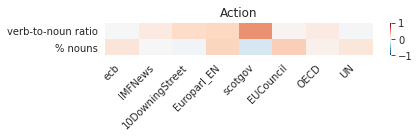

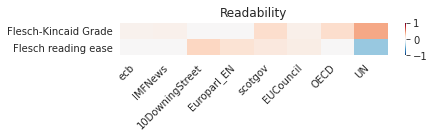

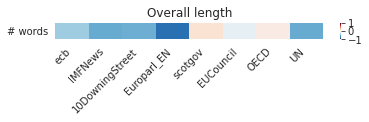

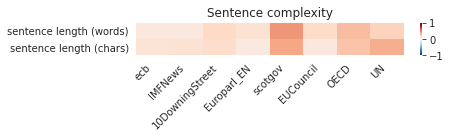

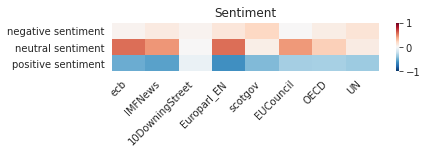

In [458]:
for c in ests.category.unique():
    sub_grouped = ests_wide[ests[ests['category']==c].target.unique().tolist()]
    # sub_grouped = (sub_grouped>0).astype(int)
    #sub_grouped=ests_wide[targets]
    plt.subplots(figsize=(6,0.3*len(sub_grouped.columns)))
    sub_grouped = sub_grouped.T[['UN', 'OECD', 'EUCouncil', 'scotgov', 'Europarl_EN', 
                                 '10DowningStreet', 'IMFNews', 'ecb'][::-1]]
    sns.heatmap(sub_grouped, cmap='RdBu_r', center=.0, vmin=-1, vmax=1)
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, ha='right')
    plt.title(c.capitalize())
    plt.savefig(f'figs/hm_{c}.png', dpi=300, bbox_inches='tight')
    plt.show()

### Results of predictive models

In [7]:
# d = json.load(open('logs/transformers/sum_count.json'))
d = json.load(open('logs/engagement/sum_count.json'))

In [8]:
tr_res = pd.DataFrame(d).sort_values(by='test_r2')
tr_res['model'] = tr_res['model'].str.replace('sum_count_', '')

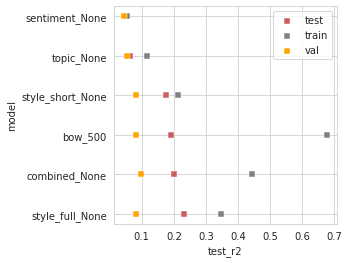

In [9]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=tr_res, x='test_r2', y='model', label='test', color='indianred', marker='s')
sns.scatterplot(data=tr_res, x='train_r2', y='model', label='train', color='grey', marker='s')
sns.scatterplot(data=tr_res, x='val_r2', y='model', label='val', color='orange', marker='s')
plt.show()

In [10]:
dfs = []
for metric in ['sum']:
    fs = glob.glob(f'logs/*/{metric}_count/pred*.pkl')
    for f in fs:
        print(f)
        f_df = pd.read_pickle(f)
        f_df['metric'] = metric
        dfs.append(f_df)
    metrics = pd.concat(dfs, ignore_index=True)
    

logs/engagement/sum_count/pred_sum_count_topic_None_train.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_train.pkl
logs/engagement/sum_count/pred_sum_count_sentiment_None_test.pkl
logs/engagement/sum_count/pred_sum_count_topic_None_val.pkl
logs/engagement/sum_count/pred_sum_count_bow_500_test.pkl
logs/engagement/sum_count/pred_sum_count_sentiment_None_val.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_val.pkl
logs/engagement/sum_count/pred_sum_count_combined_None_test.pkl
logs/engagement/sum_count/pred_sum_count_combined_None_train.pkl
logs/engagement/sum_count/pred_sum_count_bow_500_train.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_test.pkl
logs/engagement/sum_count/pred_sum_count_style_full_None_train.pkl
logs/engagement/sum_count/pred_sum_count_topic_None_test.pkl
logs/engagement/sum_count/pred_sum_count_combined_None_val.pkl
logs/engagement/sum_count/pred_sum_count_style_full_None_val.pkl
logs/engagement/sum_count/pred_sum_count_bow_5

In [11]:
spears = metrics.groupby(['metric', 'split',
                          'model_name'])[['label', 
                                          'prediction']].apply(lambda x: x.corr('spearman').iloc[0,1]).reset_index()
spears = spears.rename({0: 'spearman_cor'}, axis=1)

In [27]:
spears

,metric,split,model_name,spearman_cor
3,sum,test,sum_count_distilbert-base-uncased_lr-0.01_wdec...,0.032487
23,sum,val,sum_count_distilbert-base-uncased_lr-0.01_wdec...,0.035013
13,sum,train,sum_count_distilbert-base-uncased_lr-0.01_wdec...,0.046191
14,sum,train,sum_count_distilbert-base-uncased_lr-1e-05_wde...,0.304803
4,sum,test,sum_count_distilbert-base-uncased_lr-1e-05_wde...,0.306303
24,sum,val,sum_count_distilbert-base-uncased_lr-1e-05_wde...,0.320070
26,sum,val,sum_count_sentiment_None,0.488881
16,sum,train,sum_count_sentiment_None,0.496221
6,sum,test,sum_count_sentiment_None,0.509414
9,sum,test,sum_count_topic_None,0.564465


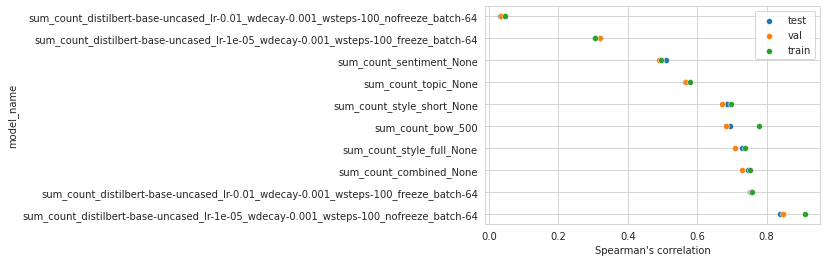

In [12]:
for metric in ['sum']:
    for out_metric in ['spearman_cor']:
        spears = spears.sort_values(by=out_metric, ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=spears[(spears['split']==split) & \
                                        (spears['metric']==metric)],
                            y='model_name', x='spearman_cor', label=split)
        plt.xlabel('Spearman\'s correlation')
        plt.show()

### Predictive models

***** sum *****
logs/engagement/sum_count/sum_count_combined_None.pkl


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


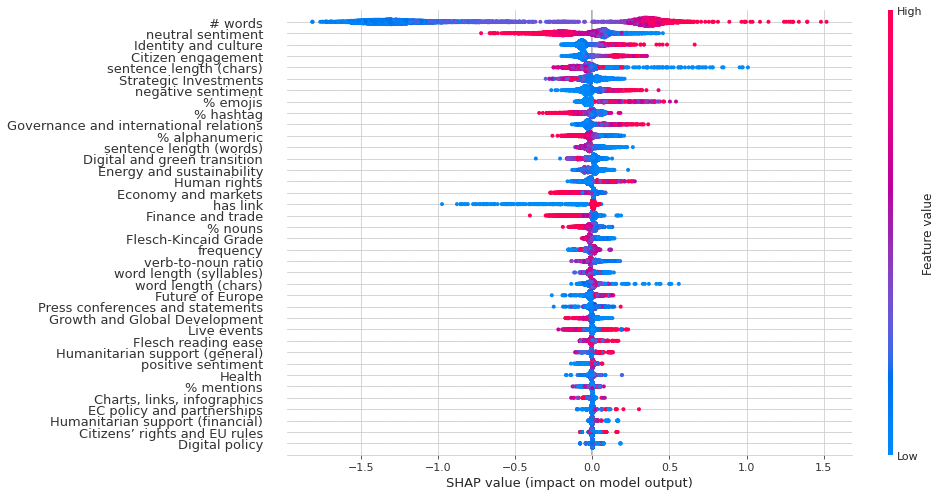

In [36]:
with xgboost.config_context(verbosity=0):
    for metric in ['sum']:
        print(f'***** {metric} *****')
        fnames = glob.glob(f'logs/engagement/{metric}_count/{metric}_count_*.pkl')
        for m in [f for f in fnames if 'combined' in f]:
            name = m.split('/')[-1]
            model = pkl.load(open(m, 'rb'))
            print(m)
            if 'topic' in m:
                feature_names = topic_col
            elif 'style_short' in m:
                feature_names = style_short
            elif 'style_full' in m:
                feature_names = style_targets
            elif 'combined' in m:
                feature_names = topic_col + emotion_col + style_targets 
            elif 'sentiment' in m:
                feature_names = emotion_col
            else:
                bow_nr = m.split('_')[-1].split('.')[0]
                tokenizer = pkl.load(open(f'logs/engagement/{metric}_count/tokenizer_bow-{bow_nr}.pkl',
                                          'rb'))
                feature_names = tokenizer.get_feature_names()
                
            df = pd.DataFrame(zip(model.feature_importances_,
                                  feature_names), 
                              columns=['importance', 'feature'])
            df = df.sort_values(by='importance')
            #plt.subplots(figsize=(20,5))
            #sns.barplot(data=df, x='feature', y='importance', color='darkgrey')
            #plt.xticks(rotation=90)
            #plt.show()
            
            shaps = pkl.load(open(f'logs/engagement/{metric}_count/shap_{name}','rb'))
            if not 'topic' in m:
                df = df.tail(n=50)
                fig, ax = plt.subplots(figsize=(20,4))    
            shap.summary_plot(shaps, max_display=50, 
                              feature_names=feature_maps, 
                              plot_size=(14,7))

    

In [32]:
new_names_topic = ['Economy and markets', 'Finance and trade',
             'Strategic Investments', 'Health',
             "Citizens’ rights and EU rules", 'Digital policy',
             'Digital and green transition', 'Energy and sustainability',
             'Identity and culture', 'Future of Europe',
             'Citizen engagement', 'Governance and international relations',
             'EC policy and partnerships', 
             'Humanitarian support (general)', 'Humanitarian support (financial)',
             'Human rights', 'Growth and Global Development', 
             'Press conferences and statements',
             'Charts, links, infographics', 'Live events']
old_names = ['economy_and_markets', 'finance_and_trade',
             'investments_recovery_growth_and_innovation', 'health',
             'citizens_rights_and_regulations', 'digital_policy',
             'digital_and_green_transition', 'sustainability_energy_and_climate',
             'identity_and_culture', 'vision_for_the_future',
             'citizens_engagement_and_culture', 
             'governance_and_international_relations',
             'eu_policies_and_partnerships', 
             'humanitarian_support_and_refugees', 
             'humanitarian_financial_aid', 
             'human_rights', 'global_goals', 
             'press_conferences_and_statements', 
             'charts_links_and_infographics', 
             'live_events']

In [33]:
topicmap = dict(zip(old_names, new_names_topic))
stylemap = dict(zip(style_targets+sentiment_targets, new_names))
feature_maps = [topicmap[f] if f in topicmap.keys() else stylemap[f] for f in feature_names]